In [1]:
%load_ext lab_black

In [2]:
import math
import os
import random
import shutil
import json
import logging
import sys
from collections import defaultdict
from datetime import datetime
from io import TextIOWrapper
from pathlib import Path
from typing import Callable, List, Sequence, Tuple

import albumentations as A
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from tqdm import tqdm

import utils
import networks

In [3]:
train_imgs = np.array(sorted(list(Path("data/box2/train_imgs/").glob("*.jpg"))))
test_imgs = np.array(sorted(list(Path("data/box2/test_imgs/").glob("*.jpg"))))

In [4]:
df = pd.read_csv("data/ori/train_df.csv")
keypoints = df.to_numpy()[:, 1:].astype(np.float32)
keypoints = np.stack([keypoints[:, 0::2], keypoints[:, 1::2]], axis=2)

In [5]:
with open("data/box2/offset.json", "r") as f:
    offsets = json.load(f)

In [6]:
class ImageDataset(Dataset):
    def __init__(self, files, offsets, keypoints=None):
        super().__init__()
        self.files = files
        self.offsets = offsets
        self.keypoints = keypoints

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        f = self.files[idx]
        img = imageio.imread(f)
        H, W, _ = img.shape
        # TODO 가로로 긴 영상이면 가로 길이가 768이 되도록 만들기
        ratio = torch.tensor([576 / W, 768 / H], dtype=torch.float32)
        img = cv2.resize(img, (576, 768))
        x = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0
        offset = torch.tensor(self.offsets[idx]["boxes"][:2], dtype=torch.int64)

        if self.keypoints is not None:
            keypoint = torch.tensor(self.keypoints[idx], dtype=torch.float32)
            keypoint[:, 0] = (keypoint[:, 0] - offset[0]) * ratio[0] / 4
            keypoint[:, 1] = (keypoint[:, 1] - offset[1]) * ratio[1] / 4
            keypoint = keypoint.type(torch.int64)
            # TODO: 나중에 augmentation 추가

            """
            # 좌표값 keypoint를 24차원 평면으로 변환
            y = torch.zeros(24, 768 // 4, 576 // 4, dtype=torch.int64)
            for i in range(24):
                y[i, keypoint[i, 1] // 4, keypoint[i, 0] // 4] = 1
            """
            # 좌표값 keypoint를 1차원 벡터의 위치 값으로 변환
            y = keypoint[:, 0] + keypoint[:, 1] * (576 // 4)

            return f.name, x, offset, ratio, y
        return f.name, x, offset, ratio

In [7]:
ds_train_total = ImageDataset(train_imgs, offsets["train"], keypoints)
ds_test = ImageDataset(test_imgs, offsets["test"])

---

## Horizontal Flip

In [8]:
x = ds_test[0][1]

In [9]:
x.shape

torch.Size([3, 768, 576])

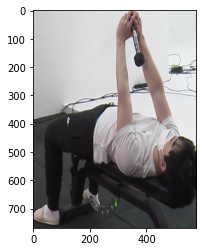

In [10]:
plt.imshow(x.permute(1, 2, 0))

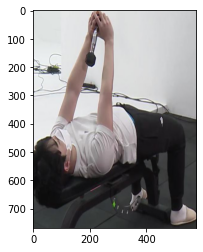

In [11]:
plt.imshow(torch.flip(x, (2,)).permute(1, 2, 0))

거울 효과로 왼쪽 오른쪽이 바뀌기 때문에 좌우가 구분된 keypoint들은 좌우를 바꿔줘야함

In [12]:
for i, c in enumerate(df.columns):
    print(i, c)

0 image
1 nose_x
2 nose_y
3 left_eye_x
4 left_eye_y
5 right_eye_x
6 right_eye_y
7 left_ear_x
8 left_ear_y
9 right_ear_x
10 right_ear_y
11 left_shoulder_x
12 left_shoulder_y
13 right_shoulder_x
14 right_shoulder_y
15 left_elbow_x
16 left_elbow_y
17 right_elbow_x
18 right_elbow_y
19 left_wrist_x
20 left_wrist_y
21 right_wrist_x
22 right_wrist_y
23 left_hip_x
24 left_hip_y
25 right_hip_x
26 right_hip_y
27 left_knee_x
28 left_knee_y
29 right_knee_x
30 right_knee_y
31 left_ankle_x
32 left_ankle_y
33 right_ankle_x
34 right_ankle_y
35 neck_x
36 neck_y
37 left_palm_x
38 left_palm_y
39 right_palm_x
40 right_palm_y
41 spine2(back)_x
42 spine2(back)_y
43 spine1(waist)_x
44 spine1(waist)_y
45 left_instep_x
46 left_instep_y
47 right_instep_x
48 right_instep_y


In [13]:
c2i = {c: i for i, c in enumerate(df.columns[1:])}

In [14]:
swap_columns = []
for i, c in enumerate(df.columns[1:]):
    if c.startswith("left_") and c.endswith("_x"):
        swap_columns.append((i // 2, c2i["right_" + c[5:]] // 2))

In [15]:
swap_columns

[(1, 2),
 (3, 4),
 (5, 6),
 (7, 8),
 (9, 10),
 (11, 12),
 (13, 14),
 (15, 16),
 (18, 19),
 (22, 23)]

In [16]:
def horizontal_flip(x, keypoints, p=0.5):
    dx = torch.flip(x, dims=(2,))
    maxw = x.size(2) // 4
    keypoints[:, 1] = maxw - keypoints[:, 1]
    for a, b in swap_columns:
        temp = keypoints[a].clone()
        keypoints[a] = keypoints[b].clone()
        keypoints[b] = temp

    return dx, keypoints

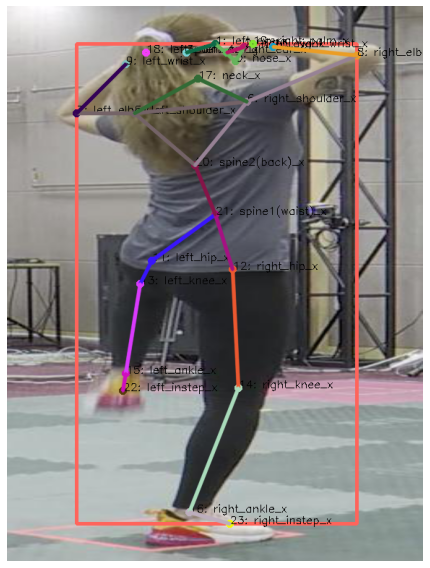

In [80]:
# 예상 출력

---

## Shift

In [17]:
x = ds_test[0][1]

In [18]:
xp = 20
yp = -20

In [19]:
dx = torch.zeros_like(x)

In [20]:
_, H, W = dx.shape

In [21]:
dxl = xp if xp >= 0 else 0
dxr = W if xp >= 0 else W + xp
dxt = yp if yp >= 0 else 0
dxb = H if yp >= 0 else H + yp
xl = 0 if xp >= 0 else -xp
xr = W - xp if xp >= 0 else W
xt = 0 if yp >= 0 else -yp
xb = H - yp if yp >= 0 else H

In [22]:
dxl, dxr, dxt, dxb

(20, 576, 0, 748)

In [23]:
xl, xr, xt, xb

(0, 556, 20, 768)

In [24]:
dx[..., dxt:dxb, dxl:dxr] = x[..., xt:xb, xl:xr]

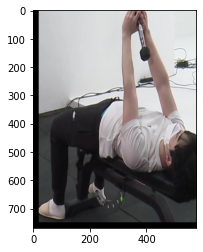

In [25]:
plt.imshow(dx.permute(1, 2, 0))

In [216]:
xmin, xmax, ymin, ymax = 9999, 0, 9999, 0
for *_, y in tqdm(ds_train_total, ncols=100):
    nums = utils.nums2keypoints(y)
    xmin = min(xmin, nums[:, 0].min())
    xmax = max(xmax, nums[:, 0].max())
    ymin = min(ymin, nums[:, 1].min())
    ymax = max(ymax, nums[:, 1].max())

100%|██████████████████████████████████████████████████████████| 4195/4195 [00:17<00:00, 235.03it/s]


In [217]:
xmin, xmax, ymin, ymax

(tensor(2), tensor(138), tensor(8), tensor(184))

In [218]:
576 / 4, 768 / 4

(144.0, 192.0)

좌2, 우6, 상8, 하6

그러므로 x는 -2-6, y는 -8-6만 가능

In [ ]:
with open("data/box2/offset.json", "r") as f:
    offsets = json.load(f)

In [97]:
offset = offsets['train'][0]
keypoint = torch.tensor(keypoints[0], dtype=torch.float32)
keypoint[:, 0] = (keypoint[:, 0] - offset[0]) * ratio[0] / 4
keypoint[:, 1] = (keypoint[:, 1] - offset[1]) * ratio[1] / 4
keypoint = keypoint.type(torch.int64)

KeyError: 0

In [98]:
def random_shift(x, keypoints, distance=20, p=0.5):
    if random.random() > p:
        return x, keypoints

    _, H, W = x.shape

    # distance = min(keypoints[:, 0].min(), W - keypoints[:, 0].max(), keypoints[:, 1].min(), H - keypoints[:, 1].max())
    # print(distance)

    # yp = random.randint(-distance, distance)
    # xp = random.randint(-distance, distance)
    xp = random.randint(-2, 2)
    yp = random.randint(-6, 6)
    keypoints[:, 0] += xp
    keypoints[:, 1] += yp

    dx = torch.zeros_like(x)
    dxl = xp if xp >= 0 else 0
    dxr = W if xp >= 0 else W + xp
    dxt = yp if yp >= 0 else 0
    dxb = H if yp >= 0 else H + yp
    xl = 0 if xp >= 0 else -xp
    xr = W - xp if xp >= 0 else W
    xt = 0 if yp >= 0 else -yp
    xb = H - yp if yp >= 0 else H
    dx[..., dxt:dxb, dxl:dxr] = x[..., xt:xb, xl:xr]

    return dx, keypoints

In [114]:
x, keypoints = random_shift(x, keypoints)

keypoints.min()

160.46791

---

## Rotate90

이미지 회전이 의미가 있을지 모르겠는데...  
테스트셋에 유독 누워있는 이미지가 많기 때문에 rotate도 나쁘지는 않을거같기도 하고?  
하지만 이미지 가로세로 사이즈 맞추는건 해줘야하나?

TODO